In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from glob import glob
from pathlib import Path
from datetime import datetime
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm.notebook import tqdm
import joblib
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


# **CONFIGURATION**
<a id='configuration'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

In [2]:
# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = "/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/"
SUBMISSION_SUFIX = "_model_2.1_31"

SELECTKBEST = False
EXPORT_DATAFRAME = True
IMPORT_DATAFRAME = False
# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
BALANCE_COLUMNS= False

RANDOM_SEED = 324

EARLY_STOPPING = 100
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")




### Set aggregations

In [3]:
# AGGREGATIONS

# D: max, min, mean
# M: 
# A : max, min, mean, sum
# L : max, min, mean, sum


APPLPREV1_AGG = {

    'num_group1':['count'],
    'actualdpd_943P': ['min','max','mean','sum','last'],
    'annuity_853A': ['min','max','mean','sum','last'],
    'approvaldate_319D':['max','min','mean','last'],
    'byoccupationinc_3656910L': ['min','max','mean','sum'],
    'cancelreason_3545846M':['max','last'],
    'childnum_21L': ['min','max','mean','sum'],
    'creationdate_885D':['min','max','mean','last'],
    'credacc_actualbalance_314A': ['min','max','mean','sum'],
    'credacc_credlmt_575A': ['min','max','mean','sum','last'],
    'credacc_maxhisbal_375A': ['min','max','mean','sum'],
    'credacc_minhisbal_90A': ['min','max','mean','sum'],
    'credacc_status_367L': ['max'],
    'credacc_transactions_402L': ['min','max','mean','sum'],
    'credamount_590A': ['min','max','mean','sum','last'],
    'credtype_587L': ['max','last'],
    'currdebt_94A': ['min','max','mean','sum','last'],
    'dateactivated_425D':['min','max','mean','last'],
    'district_544M':['max'],
    'downpmt_134A': ['min','max','mean','sum','last'],
    'dtlastpmt_581D':['min','max','mean'],
    'dtlastpmtallstes_3545839D':['min','max','mean','last'],
    'education_1138M':['max','last'],
    'employedfrom_700D':['min','max','mean','last'],
    'familystate_726L': ['max','last'],
    'firstnonzeroinstldate_307D': ['min','max','mean','last'],
    'inittransactioncode_279L': ['max','last'],
    'isbidproduct_390L': ['min','max','mean','sum','last'],
    'isdebitcard_527L': ['min','max','mean','sum'],
    'mainoccupationinc_437A': ['min','max','mean','sum','median','last'],
    'maxdpdtolerance_577P': ['min','max','mean','sum','last'],
    'outstandingdebt_522A': ['min','max','mean','sum','last'],
    'pmtnum_8L': ['min','max','mean','sum','last'],
    'postype_4733339M':['max','last'],
    #'profession_152M':['max'],
    'rejectreason_755M':['max','last'],
    'rejectreasonclient_4145042M':['max','last'],
    'revolvingaccount_394A': ['min','max','mean','sum'],
    'status_219L': ['max','last'],
    'tenor_203L': ['min','max','mean','sum'],
    
}
APPLPREV2_AGG = {
    'num_group1':['count'],
    'num_group2':['count'],
    'conts_type_509L':['max','last'],
    'cacccardblochreas_147M': ['max','last'],
    'credacc_cards_status_52L':['max'],
    
}
PERSON1_AGG={
    'num_group1':['count'],
    'birth_259D': ['max','last'],
    #'childnum_185L':['max','mean','min'],
    'contaddr_district_15M':['max'],
    'contaddr_matchlist_1032L':['max','last'],
    'contaddr_smempladdr_334L':['max','last'],
    'contaddr_zipcode_807M':['max'],
    'education_927M':['max','last'],
    'empl_employedfrom_271D':['max','mean','min'],
    'empl_employedtotal_800L':['max'],
    'empl_industry_691L':['max'],
    'empladdr_district_926M' : ['max','min','mean','last'],
    'empladdr_zipcode_114M' : ['max','min','mean','last'],
    'familystate_447L':['max','count'],
    #'gender_992L'
    'housetype_905L':['max'],
    #'housingtype_772L'
    'incometype_1044T':['max','last'],
    #'isreference_387L'
    'language1_981M':['max', 'last'],
    'mainoccupationinc_384A':['max','mean','min', 'count','last'],
    #'maritalst_703L'
    'personindex_1023L':['max','mean','min', 'count','sum','last'],
    'persontype_1072L':['max','mean','min', 'count','sum','last'],
    'persontype_792L':['max','mean','min', 'count','sum'],
    #'registaddr_district_1083M'
    #'registaddr_zipcode_184M'
    'relationshiptoclient_415T':['max','count'],
    'relationshiptoclient_642T':['max','count','last'],
    'remitter_829L':['max'],
    'role_1084L':['max','count','last'],
    #'role_993L'
    'safeguarantyflag_411L':['max','last'],
    'sex_738L':['max','last'],
    'type_25L':['max','last']
    

    
    
    
}
PERSON2_AGG={
    'num_group1':['count'],
    'num_group2':['count'],
    #'addres_district_368M'
    #'addres_role_871L'
    #'addres_zip_823M'
    'conts_role_79M':['max','last'],
    'empls_economicalst_849M':['max','last'],
    #'empls_employedfrom_796D'
    'empls_employer_name_740M':['max','last'],
    #'relatedpersons_role_762T'
}
OTHER_AGG={
    'num_group1':['count'],
    'amtdebitincoming_4809443A':['max','mean','min', 'count','sum'],
    'amtdebitoutgoing_4809440A':['max','mean','min', 'count','sum'],
    #'amtdepositbalance_4809441A'
    #'amtdepositincoming_4809444A'
    #'amtdepositoutgoing_4809442A'
}
DEBITCARD_AGG={
    'num_group1':['count'],
    #'last180dayaveragebalance_704A'
    #'last180dayturnover_1134A'
    #'last30dayturnover_651A'
    'openingdate_857D':['min','max','mean']
}
TAX_REGISTRY_A_AGG={
    'num_group1':['count'],
    'amount_4527230A': ['max','mean','min','sum'],
    'name_4527232M':['max'],
    'recorddate_4527225D':['max','mean','min']
    
}
TAX_REGISTRY_B_AGG={
    'num_group1':['count'],
    'amount_4917619A':['min','mean','max','sum'],
    'deductiondate_4917603D':['max','mean','min'],
    'name_4917606M':['max'],
    
    
}
TAX_REGISTRY_C_AGG={
    'num_group1':['count'],
    'employername_160M':['max'],
    'pmtamount_36A':['min','mean','max','sum','last'],
    'processingdate_168D':['mean','min','max','last'],

}
CREDIT_BUREAU_A_1_AGG={
    
    'num_group1':['count'],
    #'annualeffectiverate_199L'
    #'annualeffectiverate_63L'
    'classificationofcontr_13M':['max','last'],
    'classificationofcontr_400M':['max','last'],
    'contractst_545M':['max','last'],
    'contractst_964M':['max','last'],
    #'contractsum_5085717L'
    'credlmt_230A':['mean','min','max'],
    'credlmt_935A':['mean','min','max'],
    'dateofcredend_289D':['mean','min','max'],
    'dateofcredend_353D':['mean','min','max'],
    'dateofcredstart_181D':['mean','min','max'],
    'dateofcredstart_739D':['mean','min','max'],
    'dateofrealrepmt_138D':['mean','min','max'],
    'debtoutstand_525A':['min','mean','max','sum'],
    'debtoverdue_47A':['min','mean','max','sum'],
    'description_351M':['max','last'],
    'dpdmax_139P':['min','mean','max','sum'],
    'dpdmax_757P':['mean','min','max'],
    'dpdmaxdatemonth_442T':['max'],
    'dpdmaxdatemonth_89T':['max'],
    'dpdmaxdateyear_596T':['max'],
    'dpdmaxdateyear_896T':['max'],
    'financialinstitution_382M':['max','last'],
    'financialinstitution_591M':['max','last'],
    'instlamount_768A':['min','mean','max','sum'],
    #'instlamount_852A'
    #'interestrate_508L'
    'lastupdate_1112D':['mean','min','max'],
    'lastupdate_388D':['mean','min','max'],
    'monthlyinstlamount_332A':['min','mean','max','sum'],
    'monthlyinstlamount_674A':['mean','min','max'],
    'nominalrate_281L':['mean','min','max'],
    'nominalrate_498L':['max'],
    'numberofcontrsvalue_258L':['min','mean','max','sum'],
    'numberofcontrsvalue_358L':['min','mean','max','sum'],
    'numberofinstls_229L':['max'],
    'numberofinstls_320L':['min','mean','max','sum'],
    'numberofoverdueinstls_834L':['max'],
    'numberofoutstandinstls_520L':['max'],
    'numberofoutstandinstls_59L':['min','mean','max','sum'],
    'numberofoverdueinstlmax_1039L':['min','mean','max','sum'],
    'numberofoverdueinstlmax_1151L' : ['max'],
    'numberofoverdueinstlmaxdat_148D': ['max'],
    'numberofoverdueinstlmaxdat_641D':['mean', 'min','max'],
    'numberofoverdueinstls_725L':['mean','min','max'],
    'outstandingamount_354A': ['mean','min','max'],
    'outstandingamount_362A': ['mean','min','max'],
    'overdueamountmaxdatemonth_284T': ['min', 'mean', 'max'],
    'overdueamountmaxdatemonth_365T': ['min', 'mean', 'max'],
    'overdueamountmaxdateyear_2T': ['min', 'mean', 'max'],
    'overdueamountmaxdateyear_994T': ['min', 'mean', 'max'],
    'overdueamount_31A': ['min', 'mean', 'max'],
    'overdueamountmax_35A' : ['max', 'mean'],
    'overdueamountmax2_398A': ['min', 'mean', 'max'],
    'overdueamountmax2date_1002D'  : ['min', 'mean', 'max'],
    'overdueamountmax2date_1142D': ['max'],
    'overdueamount_659A': ['min', 'mean', 'max'],
    'overdueamountmax2_14A' :['min', 'mean', 'max'],
    'periodicityofpmts_1102L': ['min', 'mean', 'max'],
    'periodicityofpmts_837L': ['min', 'mean', 'max'],
    'prolongationcount_1120L': ['min', 'mean', 'max'],
    'prolongationcount_599L': ['min', 'mean', 'max'],
    'purposeofcred_426M': ['min', 'mean', 'max','last'],
    'purposeofcred_874M': ['min', 'mean', 'max','last'],
    'refreshdate_3813885D': ['min', 'mean', 'max','last'],
    'residualamount_488A': ['min', 'mean', 'max'],
    'residualamount_856A': ['min', 'mean', 'max'],
    'subjectrole_182M' : ['min', 'max', 'mean', 'last'],
    'subjectrole_93M' : ['min', 'max', 'mean', 'last'],
    'totalamount_6A': ['min', 'mean', 'max'],
    'totalamount_996A': ['min', 'mean', 'max'],
    'totaldebtoverduevalue_178A': ['min', 'mean', 'max'],
    'totaldebtoverduevalue_718A': ['min', 'mean', 'max'],
    'totaloutstanddebtvalue_39A': ['min', 'mean', 'max'],
    'totaloutstanddebtvalue_668A': ['min', 'mean', 'max']
   
}
CREDIT_BUREAU_B_1_AGG={
    'num_group1':['count'],
    
}
CREDIT_BUREAU_A_2_AGG={
 
    'collater_typofvalofguarant_298M' : ['min', 'mean', 'max', 'last'],
    'collater_typofvalofguarant_407M': ['min', 'mean', 'max', 'last'],
    'collaterals_typeofguarante_359M': ['min', 'mean', 'max', 'last'],
    'collaterals_typeofguarante_669M': ['min', 'mean', 'max', 'last'],
    'collater_valueofguarantee_1124L': ['max'],
    'collater_valueofguarantee_876L': ['max'],
    'pmts_dpd_1073P': ['min', 'mean', 'max'],
    'pmts_dpd_303P': ['min', 'mean', 'max'],
    'pmts_month_158T': ['min', 'mean', 'max','last'],
    'pmts_month_706T': ['min', 'mean', 'max','last'],
    'pmts_overdue_1140A': ['min', 'mean', 'max'],
    'pmts_overdue_1152A': ['min', 'mean', 'max'],
    'pmts_year_1139T': ['min', 'mean', 'max', 'last'],
    'pmts_year_507T': ['min', 'mean', 'max','last'],
    'subjectroles_name_541M': ['min', 'mean', 'max','count','last'],
    'subjectroles_name_838M': ['min', 'mean', 'max','count','last'],
    
    
    'num_group1':['count'],
    'num_group2':['count']
}
CREDIT_BUREAU_B_2_AGG={
    'num_group1':['count'],
    'num_group2':['count'],
    'pmts_date_1107D':['min', 'mean', 'max'],
    'pmts_dpdvalue_108P':['min','mean','max'],
    'pmts_pmtsoverdue_635A':['min','mean','max'],
}


# **MAIN FUNCTION**
<a id='main_function'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

In [4]:
def main(debug= False):
    num_rows = 111111 if debug else None
    print("Notebook started:")
    if not IMPORT_DATAFRAME:
    
        with timer("base"):

            df = get_base(DATA_DIRECTORY, num_rows=num_rows)

            print("base dataframe shape:", df.shape)



        with timer("static"):

            df_static = get_static(DATA_DIRECTORY, num_rows=num_rows)
            df_static = df_static.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_static, on='case_id', how='left', suffix='_static')
            print("static dataframe shape:", df_static.shape)
            print("DATAFRAME shape:", df.shape)

            del df_static
            gc.collect()

        with timer("static_cb"):

            df_static_cb = get_static_cb(DATA_DIRECTORY, num_rows=num_rows)
            df_static_cb = df_static_cb.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_static_cb, on='case_id', how='left', suffix='_static_cb')
            print("static cb dataframe shape:", df_static_cb.shape)
            print("DATAFRAME shape:", df.shape)
            del df_static_cb
            gc.collect()

        with timer("Previous applications depth 1 test"):

            df_applprev1 = get_applprev1(DATA_DIRECTORY, num_rows=num_rows)
            df_applprev1 = df_applprev1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_applprev1, on='case_id', how='left', suffix='_applprev1')
            print("Previous applications depth 1 test dataframe shape:", df_applprev1.shape)
            print("DATAFRAME shape:", df.shape)
            del df_applprev1
            gc.collect()

        with timer("Previous applications depth 2 test"):

            df_applprev2 = get_applprev2(DATA_DIRECTORY, num_rows=num_rows)
            df_applprev2 = df_applprev2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_applprev2, on='case_id', how='left', suffix='_applprev2')
            print("Previous applications depth 2 test dataframe shape:", df_applprev2.shape)
            print("DATAFRAME shape:", df.shape)
            del df_applprev2
            gc.collect()

        with timer("Person depth 1 test"):

            df_person1 = get_person1(DATA_DIRECTORY, num_rows=num_rows)
            df_person1 = df_person1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_person1, on='case_id', how='left', suffix='_person1')
            print("Person depth 1 test dataframe shape:", df_person1.shape)
            print("DATAFRAME shape:", df.shape)
            del df_person1
            gc.collect()

        with timer("Person depth 2 test"):

            df_person2 = get_person2(DATA_DIRECTORY, num_rows=num_rows)
            df_person2 = df_person2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_person2, on='case_id', how='left', suffix='_person2')
            print("Person depth 2 test dataframe shape:", df_person2.shape)
            print("DATAFRAME shape:", df.shape)
            del df_person2
            gc.collect()

        with timer("Other test"):

            df_other = get_other(DATA_DIRECTORY, num_rows=num_rows)
            df_other = df_other.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_other, on='case_id', how='left', suffix='_other')
            print("Other test dataframe shape:", df_other.shape)
            print("DATAFRAME shape:", df.shape)
            del df_other
            gc.collect()

        with timer("Debit card test"):

            df_debitcard = get_debitcard(DATA_DIRECTORY, num_rows=num_rows)
            df_debitcard = df_debitcard.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_debitcard, on='case_id', how='left', suffix='_debitcard')
            print("Debit card test dataframe shape:", df_debitcard.shape)
            print("DATAFRAME shape:", df.shape)
            del df_debitcard
            gc.collect()

        with timer("Tax registry a test"):

            df_tax_registry_a = get_tax_registry_a(DATA_DIRECTORY, num_rows=num_rows)
            df_tax_registry_a = df_tax_registry_a.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_tax_registry_a, on='case_id', how='left', suffix='_tax_registry_a')
            print("Tax registry a test dataframe shape:", df_tax_registry_a.shape)
            print("DATAFRAME shape:", df.shape)
            del df_tax_registry_a
            gc.collect()

        with timer("Tax registry b test"):

            df_tax_registry_b = get_tax_registry_b(DATA_DIRECTORY, num_rows=num_rows)
            df_tax_registry_b = df_tax_registry_b.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_tax_registry_b, on='case_id', how='left', suffix='_tax_registry_b')
            print("Tax registry b test dataframe shape:", df_tax_registry_b.shape)
            print("DATAFRAME shape:", df.shape)
            del df_tax_registry_b
            gc.collect()

        with timer("Tax registry c test"):

            df_tax_registry_c = get_tax_registry_c(DATA_DIRECTORY, num_rows=num_rows)
            df_tax_registry_c = df_tax_registry_c.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_tax_registry_c, on='case_id', how='left', suffix='_tax_registry_c')
            print("Tax registry c test dataframe shape:", df_tax_registry_c.shape)
            print("DATAFRAME shape:", df.shape)
            del df_tax_registry_c
            gc.collect()



        with timer("Credit bureau a 1 test"):

            df_credit_bureau_a_1 = get_credit_bureau_a_1(DATA_DIRECTORY, num_rows=num_rows)
            df_credit_bureau_a_1 = df_credit_bureau_a_1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_credit_bureau_a_1, on='case_id', how='left', suffix='_cb_a_1')
            print("Credit bureau a 1 test dataframe shape:", df_credit_bureau_a_1.shape)
            print("DATAFRAME shape:", df.shape)
            del df_credit_bureau_a_1
            gc.collect()
        with timer("Credit bureau b 1 test"):

            df_credit_bureau_b_1 = get_credit_bureau_b_1(DATA_DIRECTORY, num_rows=num_rows)
            df_credit_bureau_b_1 = df_credit_bureau_b_1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_credit_bureau_b_1, on='case_id', how='left', suffix='_cb_b_1')
            print("Credit bureau b 1 test dataframe shape:", df_credit_bureau_b_1.shape)
            print("DATAFRAME shape:", df.shape)
            del df_credit_bureau_b_1
            gc.collect()




        with timer("Credit bureau a 2 test"):

            df_credit_bureau_a_2 = get_credit_bureau_a_2(DATA_DIRECTORY, num_rows=num_rows)
            df_credit_bureau_a_2 = df_credit_bureau_a_2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_credit_bureau_a_2, on='case_id', how='left', suffix='_cb_a_2')
            print("Credit bureau a 2 test dataframe shape:", df_credit_bureau_a_2.shape)
            print("DATAFRAME shape:", df.shape)
            del df_credit_bureau_a_2
            gc.collect()

        with timer("Credit bureau b 2 test"):

            df_credit_bureau_b_2 = get_credit_bureau_b_2(DATA_DIRECTORY, num_rows=num_rows)
            df_credit_bureau_b_2 = df_credit_bureau_b_2.filter(pl.col('case_id').is_in(df['case_id'].unique()))
            df = df.join(df_credit_bureau_b_2, on='case_id', how='left', suffix='_cb_b_2')
            print("Credit bureau b 2 test dataframe shape:", df_credit_bureau_b_2.shape)
            print("DATAFRAME shape:", df.shape)
            del df_credit_bureau_b_2
            gc.collect()

        with timer("Feature engineering / preprocessing"): 

            df=feature_engineering(df)
            get_info(df)
            
            
            cols=df.columns
            imported=pd.read_csv("/kaggle/input/home-credit-2024-additional-dataset/features_575.csv")
            new_cols=imported["feature"].tolist()
            missing_cols = [col for col in cols if col not in new_cols]

            print("Columns missing in new_cols:", missing_cols)
            
            df_pandas, cat_cols = to_pandas(df)
            del df;gc.collect()
            df=df_pandas
           
            print("DATAFRAME shape:", df.shape)
            
        
    else:
        with timer("Importing processed dataframe"):
            
            
            df = pd.read_parquet("/kaggle/input/home-credit-2024-additional-dataset/processed_000.parquet", use_legacy_dataset=True)

            
         
            for col in df.select_dtypes(exclude=['number']).columns:
                df[col] = df[col].astype('category')
            
            print(df.dtypes.value_counts())
            #df=reduce_mem_usage(df)
           
            print("DATAFRAME shape:", df.shape)
            
            
    
            
    with timer("Feature selection"):    
            print("shape before selection: ", df.shape)
            df=feature_selection(df)  
            print("shape after selection: ", df.shape)
            
    with timer("Data preprocessing"):
            print("shape before preprocessing: ", df.shape)
            df=preprocessingX(df)
            print("shape after preprocessing: ", df.shape)
            
    with timer("Data transformation"):
            print("shape before transformation: ", df.shape)
            df=data_transformation(df)
            print("shape after transformation: ", df.shape)
    
  
    if EXPORT_DATAFRAME:
        with timer("Export dataframe"):
            df.to_parquet("/kaggle/working/processed_001_std.parquet", index=False)
            
            
            print("NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!")
            return
    
    if(SELECTKBEST):
        with timer("SelectKBest feature research"):
            
            selectkbestX(df)
            print("NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!")
            return

    
            
    
    print("NOTEBOOK HAS BEEN SUCCESSFULLY EXECUTED !!!")
    
    return
    
    
    

# **UTILITY FUNCTIONS**

### Pipeline

In [5]:
class Pipeline:
    @staticmethod
    
    
    # Sets datatypes accordingly
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    
    # Changes the values of all date columns. The result will not be a date but number of days since date_decision.
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.with_columns((pl.col("date_decision").dt.month()).alias("month_decision"))
        df = df.with_columns((pl.col("date_decision").dt.weekday()).alias("weekday_decision"))
        
        
        
        df = df.drop("date_decision", "MONTH")

        return df
    
    # It drops columns with a lot of NaN values.
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [6]:
def get_info(dataframe):
    """
    View data types, shape, and calculate the percentage of NaN (missing) values in each column
    of a Polars DataFrame simultaneously.
    
    Parameters:
    dataframe (polars.DataFrame): The DataFrame to analyze.
    
    Returns:
    None
    """
    # Print DataFrame shape
    print("DataFrame Shape:", dataframe.shape)
    print("-" * 60)
    
    # Print column information
    print("{:<50} {:<30} {:<20}".format("Column Name", "Data Type", "NaN Percentage"))
    print("-" * 60)
    
    # Total number of rows in the DataFrame
    total_rows = len(dataframe)
    
    # Iterate over each column
    for column in dataframe.columns:
        # Get the data type of the column
        dtype = str(dataframe[column].dtype)
        
        # Count the number of NaN values in the column
        nan_count = dataframe[column].null_count()
        
        # Calculate the percentage of NaN values
        nan_percentage = (nan_count / total_rows) * 100
        
        # Print the information
        print("{:<50} {:<30} {:.2f}%".format(column, dtype, nan_percentage))


In [7]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [9]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))


In [10]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    

    temp=base.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM").mean()
   
    week_nums_to_drop = temp[(temp["target"] == 0) | (temp["target"] == 1)].index.tolist()

    base_filtered = base[~base["WEEK_NUM"].isin(week_nums_to_drop)]

    # Apply the aggregator
    gini_in_time = base_filtered.loc[:, ["WEEK_NUM", "target", "score"]] \
        .sort_values("WEEK_NUM") \
        .groupby("WEEK_NUM")[["target", "score"]] \
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.nanmean(gini_in_time)  # Use np.nanmean to handle NaN values
    
    if SHOW_REPORT:
        # Display the plot of x on y
        plt.figure(figsize=(8, 6))
        plt.plot(x, y, 'o', label='Gini in Time')
        plt.plot(x, y_hat, '-', label='Fitted line (slope={:.2f}, intercept={:.2f})'.format(a, b))
        plt.xlabel('Week')
        plt.ylabel('Gini in Time')
        plt.title('Gini Stability Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

### Report function

In [11]:
'''
def make_report(num_rows, predictors, model):
    # 1. time
    current_time = datetime.now()
    # Print the current time
    print("Current Time:", current_time)
    
    # 2. specification
    if not num_rows:
        print("The notebook was run in full mode.")
    else:
        print("The notebook was run in debug mode. Number of rows: " + str(num_rows))
    
    # 3. features
    feat_importances_df = model.get_features_importances_df(predictors)
    feat_importances_df['gain'] = feat_importances_df['gain'].round(0)
    print(feat_importances_df.shape)
    
    predictions = pd.Series(model.get_predictions())
   
    numerical_columns = data.select_dtypes(include=['int', 'float']).columns

    # Compute correlations of each numerical column with 'PREDICTIONS'
    correlations = {}
    
    # Compute correlations of each numerical column with 'feat'
    for column in numerical_columns:
        correlations[column] = predictions.corr(data[column])

    # Create a new DataFrame with 'features' and 'correlation' columns
    correlation_df = pd.DataFrame(list(correlations.items()), columns=['features', 'correlation'])

    # Round the correlation numbers to three decimal places
    correlation_df['correlation'] = correlation_df['correlation'].round(3)

    # Merge feat_importances_df and correlation_df on 'feature'
    combined_df = pd.merge(feat_importances_df, correlation_df, left_on="feature", right_on='features', how='left')

    # Handle categorical features with no correlation
    combined_df['correlation'] = combined_df['correlation'].fillna(value=np.nan)
    

    # Compute and add valid percentage for each feature
    valid_percentage = (data[0:-10].count() / len(data[0:-10]))
    valid_percentage = valid_percentage.round(3)
    combined_df['valid_percentage'] = combined_df['feature'].map(valid_percentage)

    # Print the combined_df DataFrame
    print(combined_df.to_string(index=False))
    print()
    roc_score=roc_auc_score(data['target'][0:-10],predictions)
    print("ROC score: ",roc_score)

    # Compute false positive rate, true positive rate, and thresholds for ROC curve
    fpr, tpr, thresholds = roc_curve(data['target'][0:-10], predictions)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_score)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
'''

'\ndef make_report(num_rows, predictors, model):\n    # 1. time\n    current_time = datetime.now()\n    # Print the current time\n    print("Current Time:", current_time)\n    \n    # 2. specification\n    if not num_rows:\n        print("The notebook was run in full mode.")\n    else:\n        print("The notebook was run in debug mode. Number of rows: " + str(num_rows))\n    \n    # 3. features\n    feat_importances_df = model.get_features_importances_df(predictors)\n    feat_importances_df[\'gain\'] = feat_importances_df[\'gain\'].round(0)\n    print(feat_importances_df.shape)\n    \n    predictions = pd.Series(model.get_predictions())\n   \n    numerical_columns = data.select_dtypes(include=[\'int\', \'float\']).columns\n\n    # Compute correlations of each numerical column with \'PREDICTIONS\'\n    correlations = {}\n    \n    # Compute correlations of each numerical column with \'feat\'\n    for column in numerical_columns:\n        correlations[column] = predictions.corr(data[col

In [12]:
def group(df_to_agg, prefix, aggregations, aggregate_by='case_id', datatype='polars'):
    # Create a dictionary mapping aggregation functions to their string representations
    
    
   
    
    if datatype=='polars':
        func_mapping = {
        'min': pl.min,
        'max': pl.max,
        'mean': pl.mean,
        'sum': pl.sum,
        'count': pl.count,
         'median': pl.median,
        "last" : pl.last
        }

    # Perform the aggregation
        agg_df = df_to_agg.group_by(aggregate_by).agg(**{
            f"{func}_{col}": func_mapping[func](col) for col, funcs in aggregations.items() for func in funcs
        })
        '''
        # Rename columns
        for col, funcs in aggregations.items():
            for func in funcs:
                old_name = f"{col}_{func}"
                new_name = f"{prefix}{col}_{func.upper()}"
                agg_df = agg_df.select(pl.col(old_name).alias(new_name))
        '''
        return agg_df
    
    if datatype=='pandas':
            # Create a dictionary mapping aggregation functions to their string representations
        func_mapping = {
            'min': 'min',
            'max': 'max',
            'mean': 'mean',
            'sum': 'sum',
            'count': 'count',
            
        }

        # Perform the aggregation
        agg_df = df_to_agg.groupby(aggregate_by).agg(**{
            f"{prefix}{col}_{func.upper()}": (col, func_mapping[func]) for col, funcs in aggregations.items() for func in funcs
        }).reset_index()
        
        return agg_df

# **SELECTKBEST METHOD**

In [13]:
def selectkbestX(data):
    #########################################################################################
    def preprocessingX(data):
    
        

        def one_hot_encode(data):
            
            
            original_columns = list(data.columns)
            categories = [cat for cat in data.columns if data[cat].dtype == 'category']
            df = pd.get_dummies(data, columns= categories, dummy_na= True) #one_hot_encode the categorical features
            categorical_columns = [cat for cat in df.columns if cat not in original_columns]
            return df, categorical_columns
        
        
        df,categorical_columns=one_hot_encode(data)
        del data;gc.collect()
        
        for column in df.columns:
            # Calculate the mean value of the column excluding NaNs
            column_mean = df[column].mean()
            # Replace NaN values in the column with the mean value
            df[column].fillna(column_mean, inplace=True)

       

        return df
    #########################################################################################
    def selectkbest_base(X_train, y_train):
        
        # Define SelectKBest with desired parameters
        k = 500  # Number of top features to select
        S = SelectKBest(score_func=f_classif, k=k)

        # Fit SelectKBest on training data and transform features
        X_train_k_best = S.fit_transform(X_train, y_train)

        # Get scores assigned to each feature
        feature_scores = S.scores_
        
        # Create a DataFrame to store feature names and their scores
        feature_scores_df = pd.DataFrame({'Feature': X_train.columns, 'Score': feature_scores})

        # Sort DataFrame by scores in descending order
        #feature_scores_df_sorted = feature_scores_df.sort_values(by='Score', ascending=False)

        # Print the table of top features and their scores
      
        # Return DataFrame with feature names and their scores
        return feature_scores_df
    #########################################################################################
    
    
    df=preprocessingX(data)
    del data;gc.collect()
    
    
    
    
   
    N_CHUNKS=5
    df.drop(df[df['target'].isnull()].index, inplace=True)
    
   
    del_features = ['target', 'case_id']
    predictors = [col for col in df.columns if col not in del_features]
    
    feats_df = pd.DataFrame({'feature': predictors}, columns=['feature'])
    
    results=[]
    
    with tqdm(total=N_CHUNKS) as pbar:
        for i in range(N_CHUNKS):

            sub_df = df[df.index % N_CHUNKS == i]
            df.drop(df.index[df.index % N_CHUNKS == i], inplace=True)
            X_train=sub_df[predictors]
            y_train=sub_df['target']


            result_df=selectkbest_base(X_train, y_train)
            
            del sub_df
            gc.collect()

            results.append(result_df)
            pbar.update(1)
            
    del df; gc.collect()
    merged_df = results[0]

# Merge the remaining dataframes horizontally on the 'Feature' column
    for df_index in range(1, len(results)):
        suffix = '_' + str(df_index)  # Add a suffix to distinguish overlapping column names
        merged_df = pd.merge(merged_df, results[df_index], on='Feature', suffixes=('', suffix))

    merged_df.rename(columns={'Score': 'Score_0'}, inplace=True)
    merged_df['mean_score'] = 0
    
    for i in range(N_CHUNKS):
        merged_df['mean_score']+=merged_df["Score_"+str(i)]
    
    
    final_df=merged_df[['Feature', 'mean_score']]
    final_df = final_df.sort_values(by='mean_score', ascending=False)
    pd.set_option('display.max_rows', None)  # Show all rows
# Display the DataFrame
    print(final_df)
   

    final_df.to_csv("/kaggle/working/SelectKBest.csv")
    
    return merged_df

# **FEATURE ENGINEERING FUNCTION**

In [14]:
def feature_engineering(df):
    
    
    
    df=df.pipe(Pipeline.handle_dates) 
    #df=df.pipe(Pipeline.filter_cols)
    
    '''
     data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
                                    final credit amount on the previous application./Income of the client
    
    
    credamount_590A/byoccupationinc_3656910L
    '''
    
    
    columns_to_add = [
        (pl.col("days30_165L")/ pl.col("days360_512L")).alias("ratio_queries_30"),
        ((pl.col("days90_310L") / pl.col("days360_512L")).alias("ratio_queries_90")),
        ((pl.col("days120_123L") / pl.col("days360_512L")).alias("ratio_queries_120")),
        ((pl.col("days180_256L") / pl.col("days360_512L")).alias("ratio_queries_180")),
        
        
        ((pl.col("credamount_770A") / pl.col("max_mainoccupationinc_437A")).alias("CREDIT_INCOME_PERCENT")),
        ((pl.col("annuity_780A") / pl.col("max_mainoccupationinc_437A")).alias("ANNUITY_INCOME_PERCENT")),
        ((pl.col("credamount_770A") / pl.col("annuity_780A")).alias("CREDIT_ANNUITY_PERCENT")),
        
        ((pl.col("annuity_780A") / pl.col("credamount_770A")).alias("CREDIT_TERM")),
        ((pl.col("max_mainoccupationinc_437A") / pl.col("max_childnum_21L")).alias("CHILDREN_CNT_INCOME_PERCENT")),
        
        #data['ANNUITY_LENGTH_EMPLOYED_PERCENT'] = data['CREDIT_TERM']/ data['DAYS_EMPLOYED']
        ((pl.col("CREDIT_TERM") / pl.col("max_empl_employedfrom_271D")).alias("ANNUITY_LENGTH_EMPLOYED_PERCENT")),
        
        #data['PHONE_CHANGE_EMP_PERCENT'] = data['DAYS_LAST_PHONE_CHANGE']/data['DAYS_EMPLOYED']
        
        
        
        #((pl.col("credamount_590A") / pl.col("byoccupationinc_3656910L")).alias("credit_income_percent")),
        
        
        
        #((pl.col("collater_typofvalofguarant_298M") + pl.col("collater_typofvalofguarant_407M")).alias("sum_collater")),
        #((pl.col("collater_typofvalofguarant_298M") + pl.col("sum_collater"))).alias("ratio_collater_active")),
        #((pl.col("collater_typofvalofguarant_407M") + pl.col("sum_collater"))).alias("ratio_collater_close")),
        #((pl.col("overdueamount_31A") + pl.col("overdueamount_659A")).alias("sum_overdue_amount")),
        #((pl.col("overdueamount_31A") / pl.col("sum_overdue_amount")).alias("ratio_overdue_amount_active")),
        #((pl.col("overdueamount_659A") / pl.col("sum_overdue_amount")).alias("ratio_overdue_amount_close")),
        #((pl.col("overdueamount_31A") / pl.col("total_overdue_amount")).alias("ratio_overdue_amount_active")),
        #((pl.col("overdueamount_659A") / pl.col("total_overdue_amount")).alias("ratio_overdue_amount_close")),
        #((pl.col("totalamount")).alias("sum_totalcredit_contract")),
        #((pl.col("totalamount_503A") / pl.col("sum_totalcredit_contract")).alias("ratio_totalcredit_contract_active")),
        #((pl.col("totalamount_6A") / pl.col("sum_totalcredit_contract")).alias("ratio_totalcredit_contract_close")),
        #((pl.col("totaldebtoverduevalue_178A") / pl.col("totaldebt_9A")).alias("ratio_overdue_debt_active")),
        #((pl.col("totaldebtoverduevalue_718A") / pl.col("totaldebt_9A")).alias("ratio_overdue_debt_close")),
        #((pl.col("numberofinstls_229L") + pl.col("numberofinstls_320L")).alias("sum_instalments")),
        #((pl.col("numberofinstls_320L") / pl.col("sum_instalments")).alias("ratio_instalments_active")),
        #((pl.col("numberofinstls_229L") / pl.col("sum_instalments")).alias("ratio_instalments_close"))
    ]

# Add the calculated columns to the DataFrame
    for column in columns_to_add:
        df = df.with_columns([column])
        new_cols=["ratio_queries_30","ratio_queries_90","ratio_queries_120","ratio_queries_180","CREDIT_INCOME_PERCENT",
                               "ANNUITY_INCOME_PERCENT","CREDIT_ANNUITY_PERCENT","CREDIT_TERM","CHILDREN_CNT_INCOME_PERCENT",
                                "ANNUITY_LENGTH_EMPLOYED_PERCENT"]
    for column_name in new_cols:
        df=df.with_columns(
        pl.when(pl.col(column_name).is_infinite())
        .then(None)
        .otherwise(pl.col(column_name))
        .keep_name()
    )

        
        
    '''
    df = df.with_columns(
    'ratio_queries_30',
    df['days30_165L'] / df['days360_512L']
)
    df['ratio_queries_90'] = df['days90_310L'] / df['days360_512L']
    df['ratio_queries_120'] = df['days120_123L'] / df['days360_512L']
    df['ratio_queries_180'] = df['days180_256L'] / df['days360_512L']
    df['sum_collater'] = df['collater_typofvalofguarant_298M'] +    df['collater_typofvalofguarant_407M']
    df['ratio_collater_active'] = df['collater_typofvalofguarant_298M'] +    df['sum_collater']
    df['ratio_collater_close'] = df['collater_typofvalofguarant_407M'] +    df['sum_collater']
    df['sum_overdue_amount'] = df['overdueamount_31A'] +    df['overdueamount_659A']
    df['ratio_overdue_amount_active'] = df['overdueamount_31A'] /    df['sum_overdue_amount']
    df['ratio_overdue_amount_close'] = df['overdueamount_659A'] /    df['sum_overdue_amount']
    df['ratio_overdue_amount_active'] = df['overdueamount_31A'] /    df['total_overdue_amount']
    df['ratio_overdue_amount_close'] = df['overdueamount_659A'] /    df['total_overdue_amount']
    df['sum_totalcredit_contract'] = df['totalamount']
    df['ratio_totalcredit_contract_active'] = df['totalamount_503A'] /    df['sum_totalcredit_contract']
    df['ratio_totalcredit_contract_close'] = df['totalamount_6A'] /    df['sum_totalcredit_contract']
    df['ratio_overdue_debt_active'] = df['totaldebtoverduevalue_178A'] /    df['totaldebt_9A']
    df['ratio_overdue_debt_close'] = df['totaldebtoverduevalue_718A'] /    df['totaldebt_9A']
    df['sum_instalments'] = df['numberofinstls_229L'] +    df['numberofinstls_320L']
    df['ratio_instalments_active'] = df['numberofinstls_320L'] /    df['sum_instalments']
    df['ratio_instalments_close'] = df['numberofinstls_229L'] /    df['sum_instalments']
    '''
    df=df.pipe(Pipeline.filter_cols)
    
    columns_to_drop=[
     
   #'min_pmts_year_1139T',              
#'mean_pmts_year_1139T',                            
#'max_pmts_year_1139T',                             
#'min_pmts_year_507T' ,                               
#'mean_pmts_year_507T',                              
#'max_pmts_year_507T',
        
#        'min_overdueamountmaxdateyear_2T'  ,               
#'mean_overdueamountmaxdateyear_2T'   ,              
#'max_overdueamountmaxdateyear_2T'  ,              
#'min_overdueamountmaxdateyear_994T'  ,              
#'mean_overdueamountmaxdateyear_994T' ,             
#'max_overdueamountmaxdateyear_994T'
]
    columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]

    df=df.drop(columns_to_drop_existing)
    
    
    
    features400=[
            #0
        'max_role_1084L', 'max_language1_981M', 'max_sex_738L','max_incometype_1044T','max_education_927M',
        'max_type_25L','max_safeguarantyflag_411L','min_pmts_month_158T','min_pmts_month_706T','max_pmts_month_158T',
        'max_pmts_month_706T','mean_pmts_month_706T','mean_pmts_month_158T','pctinstlsallpaidlate1d_3546856L','pctinstlsallpaidlate4d_3546849L',
        'pctinstlsallpaidlate6d_3546844L','pctinstlsallpaidlat10d_839L','max_contaddr_smempladdr_334L','max_contaddr_matchlist_1032L','numinstlswithdpd10_728L',
        'pctinstlsallpaidearl3d_427L','lastrejectreason_759M','days120_123L','days180_256L','days90_310L',
        'lastrejectreasonclient_4145040M','lastcancelreason_561M','lastst_736L','numrejects9m_859L',
        'avgmaxdpdlast9m_3716943P','numberofqueries_373L','days360_512L','days30_165L','mobilephncnt_593L',
        'max_birth_259D','numcontrs3months_479L','dateofbirth_337D','numinstpaidearly3d_3546850L','sum_maxdpdtolerance_577P',
        'max_maxdpdtolerance_577P','numinstlallpaidearly3d_817L','maxdpdtolerance_374P','numinstlsallpaid_934L','daysoverduetolerancedd_3976961L',
        'max_employedfrom_700D','mean_maxdpdtolerance_577P','mean_employedfrom_700D','numinstpaidearly_338L','avgdpdtolclosure24_3658938P',
        
        'mean_pmtnum_8L','mean_tenor_203L','lastrejectdate_50D','numinstlswithoutdpd_562L','avgdbddpdlast24m_3658932P',
        'max_pmtnum_8L','max_tenor_203L','numinstpaidearly3dest_4493216L','numinstmatpaidtearly2d_4499204L','min_employedfrom_700D',
        'requesttype_4525192L','maxdpdfrom6mto36m_3546853P','maxdpdlast24m_143P','datelastinstal40dpd_247D','mindbddpdlast24m_3658935P',
        'amtinstpaidbefduel24m_4187115A','avgdbdtollast24m_4525197P','maxdpdlast12m_727P','maxdbddpdtollast12m_3658940P',
        'max_empl_employedfrom_271D','min_empl_employedfrom_271D','mean_empl_employedfrom_271D','min_maxdpdtolerance_577P','firstclxcampaign_1125D',
        'max_status_219L','sum_pmtnum_8L','sum_tenor_203L','monthsannuity_845L','pmtnum_254L',
        'max_education_1138M','maxdpdlast9m_1059P','sum_amount_4527230A','mindbdtollast24m_4525191P','min_subjectroles_name_541M',
        'birthdate_574D','max_subjectroles_name_838M','max_subjectroles_name_541M','min_subjectroles_name_838M','ratio_queries_120',
        'ratio_queries_90','mean_outstandingdebt_522A','cntpmts24_3658933L','ratio_queries_180','maxdbddpdtollast6m_4187119P',
        'mean_currdebt_94A','max_familystate_726L','numinstregularpaidest_4493210L','numincomingpmts_3546848L','numinstpaid_4499208L',
        
         'numinstregularpaid_973L','disbursedcredamount_1113A','secondquarter_766L','pmtssum_45A','min_dtlastpmtallstes_3545839D',
        'count_num_group1_tax_registry_a','max_inittransactioncode_279L','max_credtype_587L','max_conts_type_509L','min_isbidproduct_390L',
        'max_rejectreasonclient_4145042M','max_rejectreason_755M','max_isbidproduct_390L','max_amount_4527230A','mean_pmts_dpd_303P',
        'maxdpdlast6m_474P','mean_firstnonzeroinstldate_307D','max_relationshiptoclient_642T','sum_credamount_590A','credamount_770A',
        'pmtscount_423L','numinstunpaidmaxest_4493212L','numinsttopaygrest_4493213L','avgdbddpdlast3m_4187120P',
        'numinsttopaygr_769L','sum_credacc_actualbalance_314A','numinstunpaidmax_3546851L','max_empl_employedtotal_800L','price_1097A',
        'ratio_queries_30','max_postype_4733339M','mean_creationdate_885D','maxdebt4_972A',
        'mean_amount_4527230A','thirdquarter_1082L','sum_mainoccupationinc_437A','sum_pmtamount_36A','maxdpdinstldate_3546855D',
        'min_purposeofcred_874M','max_description_351M','description_5085714M','min_dtlastpmt_581D',
        'totaldebt_9A','max_contractst_964M','currdebt_22A','min_firstnonzeroinstldate_307D',
        
         'max_contractst_545M','max_purposeofcred_426M','max_pmts_dpd_303P',
        'max_classificationofcontr_13M','max_financialinstitution_591M','max_classificationofcontr_400M','max_financialinstitution_382M','count_num_group1',
        'eir_270L','interestrate_311L','min_purposeofcred_426M','maxdbddpdlast1m_3658939P',
        'sum_revolvingaccount_394A','max_firstnonzeroinstldate_307D','min_dateactivated_425D','firstdatedue_489D','min_approvaldate_319D',
        'min_refreshdate_3813885D','totalsettled_863A','count_persontype_1072L','max_credacc_cards_status_52L','min_creationdate_885D',
        'max_pmtamount_36A','min_pmtnum_8L','min_tenor_203L','count_num_group1_tax_registry_c','max_credacc_status_367L',
        'sumoutstandtotalest_4493215A','datelastunpaid_3546854D','sum_persontype_1072L','sumoutstandtotal_3546847A',
        'numinstls_657L','mean_dtlastpmtallstes_3545839D','max_familystate_447L','mean_pmtamount_36A',
        'max_purposeofcred_874M','maxdpdlast3m_392P','mean_credacc_actualbalance_314A','currdebtcredtyperange_828A',
        'sum_persontype_792L','lastapplicationdate_877D','max_creationdate_885D','max_outstandingdebt_522A','max_credacc_actualbalance_314A',
        
        'max_currdebt_94A','max_pmts_dpd_1073P','mean_credamount_590A','sum_personindex_1023L','min_credacc_actualbalance_314A',
        'sum_outstandingdebt_522A','min_amount_4527230A','mean_persontype_792L','mean_credacc_credlmt_575A','lastactivateddate_801D',
        'sum_currdebt_94A','count_personindex_1023L','count_relationshiptoclient_642T','max_dateactivated_425D','max_housetype_905L',
        'min_currdebt_94A','max_relationshiptoclient_415T','min_lastupdate_388D','min_processingdate_168D',
        'min_dateofrealrepmt_138D','mean_lastupdate_388D','max_persontype_1072L','max_persontype_792L','min_pmtamount_36A',
        'lastapprcommoditycat_1041M','pmtaverage_4527227A','annuity_780A','mean_dateofrealrepmt_138D',
        'sum_annuity_853A','mean_pmts_dpd_1073P','min_credacc_credlmt_575A','lastapprdate_640D','mean_credacc_minhisbal_90A',
        'min_dateofcredend_353D','mean_dtlastpmt_581D','max_credacc_minhisbal_90A','avgoutstandbalancel6m_4187114A','max_approvaldate_319D',
        'maxannuity_159A','min_credacc_minhisbal_90A','sum_amount_4917619A','cntincpaycont9m_3716944L','min_dateofcredstart_181D',
        'mean_refreshdate_3813885D','max_remitter_829L','pmtaverage_3A','avglnamtstart24m_4525187A','education_1103M',
       'mean_dpdmax_139P','mean_numberofoverdueinstlmax_1039L','min_recorddate_4527225D','min_annuity_853A',
        'max_dpdmax_139P','sum_dpdmax_139P','lastdelinqdate_224D','mean_persontype_1072L',
        'count_num_group1_cb_a_2','count_num_group2_cb_a_2','twobodfilling_608L','sum_numberofoverdueinstlmax_1039L','homephncnt_628L',
        'count_num_group1_tax_registry_b','datefirstoffer_1144D','max_numberofoverdueinstlmax_1039L','min_numberofoverdueinstlmax_1039L',
        'mean_downpmt_134A','max_empls_economicalst_849M','min_revolvingaccount_394A','responsedate_4527233D',
        'sum_isbidproduct_390L','max_mainoccupationinc_437A','count_familystate_447L','min_dateofcredstart_739D','max_amount_4917619A',
        'mean_dateofcredend_353D','min_dpdmax_139P','mean_revolvingaccount_394A','maininc_215A','lastrejectcredamount_222A',
        'max_processingdate_168D','min_totaldebtoverduevalue_178A','inittransactioncode_186L','max_deductiondate_4917603D',
        'min_deductiondate_4917603D','mean_processingdate_168D','contractssum_5085716L','mean_dateofcredstart_181D','applicationscnt_867L',
        'mean_amount_4917619A','max_revolvingaccount_394A','mean_isbidproduct_390L','mean_dateofcredstart_739D','min_pmts_dpd_1073P',
        
        'sum_credacc_credlmt_575A','min_pmts_dpd_303P','lastapprcredamount_781A','max_empl_industry_691L',
        'min_amount_4917619A','mean_annuity_853A',
       'max_overdueamountmaxdatemonth_365T','max_downpmt_134A','disbursementtype_67L',
        'min_overdueamountmaxdatemonth_284T','sum_numberofcontrsvalue_358L','count_num_group1_person2','sum_byoccupationinc_3656910L','mean_deductiondate_4917603D',
        'sellerplacescnt_216L','mean_overdueamountmaxdatemonth_365T','max_overdueamountmaxdatemonth_284T','mean_approvaldate_319D','credtype_322L',
        'max_numberofcontrsvalue_358L','mean_numberofcontrsvalue_358L','min_downpmt_134A','min_credacc_maxhisbal_375A','mean_isdebitcard_527L',
        'min_mainoccupationinc_384A','bankacctype_710L','mean_pmts_overdue_1152A','min_numberofcontrsvalue_358L','min_mainoccupationinc_437A',
        'min_residualamount_856A','mean_byoccupationinc_3656910L','downpmt_116A','isbidproduct_1095L','clientscnt12m_3712952L',
        'mean_credacc_maxhisbal_375A','max_nominalrate_281L','mean_dateactivated_425D','sum_downpmt_134A','mean_totaldebtoverduevalue_178A',
        
         'mean_numberofinstls_320L','max_numberofinstls_320L','max_isdebitcard_527L','mean_nominalrate_281L','dtlastpmtallstes_4499206D',
        'max_lastupdate_388D','responsedate_4917613D','sum_credacc_minhisbal_90A','max_byoccupationinc_3656910L',
        'min_credacc_transactions_402L','min_instlamount_768A','inittransactionamount_650A','max_totaldebtoverduevalue_178A','min_isdebitcard_527L',
        'clientscnt6m_3712949L','mean_credacc_transactions_402L','max_credacc_maxhisbal_375A','min_numberofinstls_320L','mean_totalamount_996A',
        'validfrom_1069D','count_num_group1_cb_a_1','mean_residualamount_856A','max_debtoverdue_47A',
        'max_dateofrealrepmt_138D','mean_totalamount_6A','min_pmts_overdue_1152A',"max_cancelreason_3545846M",
    ]
    
    features125=[
        
        'max_role_1084L', 'max_language1_981M', 'max_sex_738L','max_incometype_1044T','max_education_927M',
        'max_type_25L','max_safeguarantyflag_411L','min_pmts_month_158T','min_pmts_month_706T','max_pmts_month_158T',
        'max_pmts_month_706T','mean_pmts_month_706T','mean_pmts_month_158T','pctinstlsallpaidlate1d_3546856L','pctinstlsallpaidlate4d_3546849L',
        'pctinstlsallpaidlate6d_3546844L','pctinstlsallpaidlat10d_839L','max_contaddr_smempladdr_334L','max_contaddr_matchlist_1032L','numinstlswithdpd10_728L',
        'pctinstlsallpaidearl3d_427L','lastrejectreason_759M','days120_123L','days180_256L','days90_310L',
        'lastrejectreasonclient_4145040M','lastcancelreason_561M','lastst_736L','numrejects9m_859L',
        'avgmaxdpdlast9m_3716943P','numberofqueries_373L','days360_512L','days30_165L','mobilephncnt_593L',
        'max_birth_259D','numcontrs3months_479L','dateofbirth_337D','numinstpaidearly3d_3546850L','sum_maxdpdtolerance_577P',
        'max_maxdpdtolerance_577P','numinstlallpaidearly3d_817L','maxdpdtolerance_374P','numinstlsallpaid_934L','daysoverduetolerancedd_3976961L',
        'max_employedfrom_700D','mean_maxdpdtolerance_577P','mean_employedfrom_700D','numinstpaidearly_338L','avgdpdtolclosure24_3658938P',
        
        'mean_pmtnum_8L','mean_tenor_203L','lastrejectdate_50D','numinstlswithoutdpd_562L','avgdbddpdlast24m_3658932P',
        'max_pmtnum_8L','max_tenor_203L','numinstpaidearly3dest_4493216L','numinstmatpaidtearly2d_4499204L','min_employedfrom_700D',
        'requesttype_4525192L','maxdpdfrom6mto36m_3546853P','maxdpdlast24m_143P','datelastinstal40dpd_247D','mindbddpdlast24m_3658935P',
        'amtinstpaidbefduel24m_4187115A','avgdbdtollast24m_4525197P','maxdpdlast12m_727P','maxdbddpdtollast12m_3658940P',
        'max_empl_employedfrom_271D','min_empl_employedfrom_271D','mean_empl_employedfrom_271D','min_maxdpdtolerance_577P','firstclxcampaign_1125D',
        'max_status_219L','sum_pmtnum_8L','sum_tenor_203L','monthsannuity_845L','pmtnum_254L',
        'max_education_1138M','maxdpdlast9m_1059P','sum_amount_4527230A','mindbdtollast24m_4525191P','min_subjectroles_name_541M',
        'birthdate_574D','max_subjectroles_name_838M','max_subjectroles_name_541M','min_subjectroles_name_838M','ratio_queries_120',
        'ratio_queries_90','mean_outstandingdebt_522A','cntpmts24_3658933L','ratio_queries_180','maxdbddpdtollast6m_4187119P',
        'mean_currdebt_94A','max_familystate_726L','numinstregularpaidest_4493210L','numincomingpmts_3546848L','numinstpaid_4499208L',
         'numinstregularpaid_973L','disbursedcredamount_1113A','secondquarter_766L','pmtssum_45A','min_dtlastpmtallstes_3545839D',
        'count_num_group1_tax_registry_a','max_inittransactioncode_279L','max_credtype_587L','max_conts_type_509L','min_isbidproduct_390L',
        'max_rejectreasonclient_4145042M','max_rejectreason_755M','max_isbidproduct_390L','max_amount_4527230A','mean_pmts_dpd_303P',
        'maxdpdlast6m_474P','mean_firstnonzeroinstldate_307D','max_relationshiptoclient_642T','sum_credamount_590A','credamount_770A',
        'pmtscount_423L','max_empl_industry_691L','numinstunpaidmaxest_4493212L','numinsttopaygrest_4493213L','avgdbddpdlast3m_4187120P',
        
    ]
    
    features200=[
         'max_role_1084L', 'max_language1_981M', 'max_sex_738L','max_incometype_1044T','max_education_927M',
        'max_type_25L','max_safeguarantyflag_411L','min_pmts_month_158T','min_pmts_month_706T','max_pmts_month_158T',
        'max_pmts_month_706T','mean_pmts_month_706T','mean_pmts_month_158T','pctinstlsallpaidlate1d_3546856L','pctinstlsallpaidlate4d_3546849L',
        'pctinstlsallpaidlate6d_3546844L','pctinstlsallpaidlat10d_839L','max_contaddr_smempladdr_334L','max_contaddr_matchlist_1032L','numinstlswithdpd10_728L',
        'pctinstlsallpaidearl3d_427L','lastrejectreason_759M','days120_123L','days180_256L','days90_310L',
        'lastrejectreasonclient_4145040M','lastcancelreason_561M','lastst_736L','numrejects9m_859L',
        'avgmaxdpdlast9m_3716943P','numberofqueries_373L','days360_512L','days30_165L','mobilephncnt_593L',
        'max_birth_259D','numcontrs3months_479L','dateofbirth_337D','numinstpaidearly3d_3546850L','sum_maxdpdtolerance_577P',
        'max_maxdpdtolerance_577P','numinstlallpaidearly3d_817L','maxdpdtolerance_374P','numinstlsallpaid_934L','daysoverduetolerancedd_3976961L',
        'max_employedfrom_700D','mean_maxdpdtolerance_577P','mean_employedfrom_700D','numinstpaidearly_338L','avgdpdtolclosure24_3658938P',
        
        'mean_pmtnum_8L','mean_tenor_203L','lastrejectdate_50D','numinstlswithoutdpd_562L','avgdbddpdlast24m_3658932P',
        'max_pmtnum_8L','max_tenor_203L','numinstpaidearly3dest_4493216L','numinstmatpaidtearly2d_4499204L','min_employedfrom_700D',
        'requesttype_4525192L','maxdpdfrom6mto36m_3546853P','maxdpdlast24m_143P','datelastinstal40dpd_247D','mindbddpdlast24m_3658935P',
        'amtinstpaidbefduel24m_4187115A','avgdbdtollast24m_4525197P','maxdpdlast12m_727P','maxdbddpdtollast12m_3658940P',
        'max_empl_employedfrom_271D','min_empl_employedfrom_271D','mean_empl_employedfrom_271D','min_maxdpdtolerance_577P','firstclxcampaign_1125D',
        'max_status_219L','sum_pmtnum_8L','sum_tenor_203L','monthsannuity_845L','pmtnum_254L',
        'max_education_1138M','maxdpdlast9m_1059P','sum_amount_4527230A','mindbdtollast24m_4525191P','min_subjectroles_name_541M',
        'birthdate_574D','max_subjectroles_name_838M','max_subjectroles_name_541M','min_subjectroles_name_838M','ratio_queries_120',
        'ratio_queries_90','mean_outstandingdebt_522A','cntpmts24_3658933L','ratio_queries_180','maxdbddpdtollast6m_4187119P',
        'mean_currdebt_94A','max_familystate_726L','numinstregularpaidest_4493210L','numincomingpmts_3546848L','numinstpaid_4499208L',
        
         'numinstregularpaid_973L','disbursedcredamount_1113A','secondquarter_766L','pmtssum_45A','min_dtlastpmtallstes_3545839D',
        'count_num_group1_tax_registry_a','max_inittransactioncode_279L','max_credtype_587L','max_conts_type_509L','min_isbidproduct_390L',
        'max_rejectreasonclient_4145042M','max_rejectreason_755M','max_isbidproduct_390L','max_amount_4527230A','mean_pmts_dpd_303P',
        'maxdpdlast6m_474P','mean_firstnonzeroinstldate_307D','max_relationshiptoclient_642T','sum_credamount_590A','credamount_770A',
        'pmtscount_423L','numinstunpaidmaxest_4493212L','numinsttopaygrest_4493213L','avgdbddpdlast3m_4187120P',
        'numinsttopaygr_769L','sum_credacc_actualbalance_314A','numinstunpaidmax_3546851L','max_empl_employedtotal_800L','price_1097A',
        'ratio_queries_30','max_postype_4733339M','mean_creationdate_885D','maxdebt4_972A',
        'mean_amount_4527230A','thirdquarter_1082L','sum_mainoccupationinc_437A','sum_pmtamount_36A','maxdpdinstldate_3546855D',
        'min_purposeofcred_874M','max_description_351M','description_5085714M','min_dtlastpmt_581D',
        'totaldebt_9A','max_contractst_964M','currdebt_22A','min_firstnonzeroinstldate_307D',
        
         'max_contractst_545M','max_purposeofcred_426M','max_pmts_dpd_303P',
        'max_classificationofcontr_13M','max_financialinstitution_591M','max_classificationofcontr_400M','max_financialinstitution_382M','count_num_group1',
        'eir_270L','interestrate_311L','min_purposeofcred_426M','maxdbddpdlast1m_3658939P',
        'sum_revolvingaccount_394A','max_firstnonzeroinstldate_307D','min_dateactivated_425D','firstdatedue_489D','min_approvaldate_319D',
        'min_refreshdate_3813885D','totalsettled_863A','count_persontype_1072L','max_credacc_cards_status_52L','min_creationdate_885D',
        'max_pmtamount_36A','min_pmtnum_8L','min_tenor_203L','count_num_group1_tax_registry_c','max_credacc_status_367L',
        'sumoutstandtotalest_4493215A','datelastunpaid_3546854D','sum_persontype_1072L','sumoutstandtotal_3546847A',
        'numinstls_657L','mean_dtlastpmtallstes_3545839D','max_familystate_447L','mean_pmtamount_36A',
        'max_purposeofcred_874M','maxdpdlast3m_392P','mean_credacc_actualbalance_314A','currdebtcredtyperange_828A',
        'sum_persontype_792L','lastapplicationdate_877D','max_creationdate_885D','max_outstandingdebt_522A','max_credacc_actualbalance_314A',
        
        'max_currdebt_94A','max_pmts_dpd_1073P','mean_credamount_590A','sum_personindex_1023L','min_credacc_actualbalance_314A',
        'sum_outstandingdebt_522A','min_amount_4527230A','mean_persontype_792L','mean_credacc_credlmt_575A','lastactivateddate_801D',
        'sum_currdebt_94A','count_personindex_1023L','count_relationshiptoclient_642T','max_dateactivated_425D','max_housetype_905L',
        'min_currdebt_94A','max_relationshiptoclient_415T','min_lastupdate_388D','min_processingdate_168D',
        'min_dateofrealrepmt_138D','mean_lastupdate_388D','max_persontype_1072L','max_persontype_792L','min_pmtamount_36A',
        'lastapprcommoditycat_1041M','pmtaverage_4527227A','annuity_780A','mean_dateofrealrepmt_138D'
    ]
    seen = set()
    duplicates = []
    for item in features400:
        if item in seen:
            duplicates.append(item)
        else:
            seen.add(item)
    print("duplicates:")
    print(duplicates)
    print()
    
    print("Length of features400: ", len(features400))
    print("Length of features200: ", len(features200))
    print("Length of features125: ", len(features125))
    missing_columns = [col for col in features400 if col not in df.columns]

    # Print missing columns, if any
    if missing_columns:
        print("The following columns are missing in the DataFrame:")
        for col in missing_columns:
            print(col)
    else:
        print("All columns from features400 are present in the DataFrame.")
    
    # Columns to preserve
    preserved_columns = ['target', 'case_id', 'WEEK_NUM']

    # Identify columns to drop excluding the preserved columns
    columns_to_drop = [col for col in df.columns if col not in preserved_columns + features125]

    # Drop columns that are not in features_selected and not preserved
    
    #df=df.drop(columns=columns_to_drop)
    
    test = df.filter(df['target'].is_null())
    if BALANCE_COLUMNS and len(test)>10:

        train = df.filter(df['target'].is_not_null())
        

        valid_percentage_train = []
        valid_percentage_test=[]
        for col in df.columns:
            valid_percentage_train.append(train[col].count())
            valid_percentage_test.append(test[col].count())

        valid_percentage_train = pd.Series(valid_percentage_train)
        valid_percentage_test= pd.Series(valid_percentage_test)

        print(train.count())
        print(test.count())
        print("length of train",len(valid_percentage_train))
        print("length of test",len(valid_percentage_test))
        print("df columns",len(df.columns))

        info_df = pd.DataFrame({'column': df.columns, 'valid_train': valid_percentage_train, 'valid_test': valid_percentage_test})
        irrelevant_columns = info_df[info_df['valid_test'] < 0.05 ]['column'].to_list()
        columns_to_drop = [col for col in df.columns if (col not in preserved_columns) and (col in irrelevant_columns) ]
        df = df.drop(columns=columns_to_drop)

    return df

# **FEATURE SELECTION**

In [15]:
def feature_selection(data):
    
    features_df=pd.read_csv("/kaggle/input/home-credit-2024-additional-dataset/feature_importance_model_2.1_31.csv")
    
    print(features_df.head())
    print(features_df.describe())
    df_sorted_gain = features_df.sort_values(by='gain', ascending=False)
    df_sorted_split = features_df.sort_values(by='split', ascending=False)

    # Plot sorted by gain
    plt.figure(figsize=(6, 6))
    plt.barh(range(len(df_sorted_gain)), df_sorted_gain['gain'], color='skyblue')
    plt.xlabel('Gain')
    plt.title('Feature Gain')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot sorted by split
    plt.figure(figsize=(6, 6))
    plt.barh(range(len(df_sorted_split)), df_sorted_split['split'], color='lightgreen')
    plt.xlabel('Split')
    plt.title('Feature Split')
    plt.gca().invert_yaxis()
    plt.show()
    
    
    print("Shape before selection ", data.shape)
    top_200_features_by_gain = df_sorted_gain['feature'].head(200).tolist()
    print("[{}]".format(", ".join(['"{}"'.format(feature) for feature in top_200_features_by_gain])))
    
    
    columns_to_keep = ["case_id", "date_decision", "WEEK_NUM", "MONTH", "target"]
    columns_to_drop = [col for col in data.columns if col not in top_200_features_by_gain and col not in columns_to_keep]
    df = data.drop(columns=columns_to_drop)
    print("Shape after selection ", df.shape)
    
    
    
    return df
    

In [16]:
'''
df = get_base(DATA_DIRECTORY)
df_applprev1 = get_applprev1(DATA_DIRECTORY)
df_applprev1 = df_applprev1.filter(pl.col('case_id').is_in(df['case_id'].unique()))
df = df.join(df_applprev1, on='case_id', how='left', suffix='_applprev1')
print("Previous applications depth 1 test dataframe shape:", df_applprev1.shape)
print("DATAFRAME shape:", df.shape)
del df_applprev1
gc.collect()


df=feature_engineering(df)
print(df['credit_income_percent'])
'''

'\ndf = get_base(DATA_DIRECTORY)\ndf_applprev1 = get_applprev1(DATA_DIRECTORY)\ndf_applprev1 = df_applprev1.filter(pl.col(\'case_id\').is_in(df[\'case_id\'].unique()))\ndf = df.join(df_applprev1, on=\'case_id\', how=\'left\', suffix=\'_applprev1\')\nprint("Previous applications depth 1 test dataframe shape:", df_applprev1.shape)\nprint("DATAFRAME shape:", df.shape)\ndel df_applprev1\ngc.collect()\n\n\ndf=feature_engineering(df)\nprint(df[\'credit_income_percent\'])\n'

# **DATA PREPROCESSING**

In [17]:
def preprocessingX(data):
    
        

        def one_hot_encode(data):
            
            
            original_columns = list(data.columns)
            categories = [cat for cat in data.columns if data[cat].dtype == 'category']
            df = pd.get_dummies(data, columns= categories, dummy_na= True) #one_hot_encode the categorical features
            categorical_columns = [cat for cat in df.columns if cat not in original_columns]
            return df, categorical_columns
        
        
        df,categorical_columns=one_hot_encode(data)
        del data;gc.collect()
        
        total_nan_count = df.isna().sum().sum()

        print("Total count of NaN values in the DataFrame:", total_nan_count)
        for column in (set(df.columns)-{'target'}):
            # Calculate the mean value of the column excluding NaNs
           
            
            
            df[column]=df[column].fillna(0)

        total_nan_count = df.isna().sum().sum()

        print("Total count of NaN values in the DataFrame:", total_nan_count)

        return df

# **DATA TRANFORMATION**

In [18]:
def data_transformation(data):
    print("shape before preprocessing", data.shape)
    df = preprocessingX(data)
    print("shape after preprocessing", df.shape)
    
    print("Column names:", df.columns)  # Print out the column names for debugging
    
    print("shape before normalizing", df.shape)
    cols_to_keep = ['target', 'case_id', 'MONTH', "WEEK_NUM", "date_decision"]
    cols_to_standardize = [col for col in df.columns if col not in cols_to_keep]
    transformed_cols_dfs=[]
    with tqdm(total=len(cols_to_standardize), desc="Processing columns") as pbar:
        # Iterate through columns and update the progress bar
        for col in cols_to_standardize:
            try:
                col_series = df[col].copy().values.reshape(-1, 1)
                df = df.drop(columns=[col])  # Using df.drop() instead of df.pop() to drop the column
                scaler = StandardScaler()
                scaled_col_series = scaler.fit_transform(col_series)
                clipped_scaled_col_series=np.clip(scaled_col_series, -5, 5)
                
                
                col_df = pd.DataFrame(clipped_scaled_col_series.flatten(), columns=[col])
                transformed_cols_dfs.append(col_df)
                del scaler
                gc.collect()
            except KeyError:
                print(f"Column '{col}' not found in the DataFrame.")
            
            # Update the progress bar
            pbar.update(1)
    
    transformed_cols_dfs.append(df)
    df = pd.concat(transformed_cols_dfs, axis=1)
    
    
    print("shape after normalizing", df.shape)
    print()
    
    for column in df.columns:
        min_value = data[column].min()
        max_value = data[column].max()
        print(f"Column: {column}, Min Value: {min_value}, Max Value: {max_value}")
    return df

# **GET FUNCTIONS**

### get_base()

In [19]:
def get_base(path, num_rows = None):
    # Read the Parquet file using scan() method
    train={}
    test={}
    
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_base.parquet'))
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_base.parquet')).limit(num_rows) 
        
    test = pl.read_parquet(os.path.join(path, 'test/test_base.parquet'))    
    length=len(test)
    nan_series=pl.Series([None] * length)
    test = test.select(pl.col("*"), nan_series.alias("target"))
    df=pl.concat([train, test])
    del test;del train;gc.collect()
    
    
    df = df.with_columns(pl.col('date_decision').cast(pl.Date))
    return df

### get_static()

In [20]:
def get_static(path, num_rows = None):
# Read the Parquet file using scan() method
    chunks = []
    for path in glob(DATA_DIRECTORY+str('train/train_static_0_*.parquet')):
        chunks.append(pl.read_parquet(path,low_memory=True).pipe(Pipeline.set_table_dtypes) )
    train = (pl.concat(chunks, how="vertical_relaxed")).pipe(Pipeline.filter_cols)
    
    if num_rows!= None:
        df1 = train.slice(0,num_rows)
        df2 = train.slice(num_rows,len(train))
        
        train=df1
        del df2
        gc.collect()
    chunks = []
    for path in glob(DATA_DIRECTORY+str('test/test_static_0_*.parquet')):
        chunks.append(pl.read_parquet(path,low_memory=True).pipe(Pipeline.set_table_dtypes) )
    test = pl.concat(chunks, how="vertical_relaxed")
    
    
    columns_to_keep = train.columns

# Find columns in 'test' that are not in 'train'
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]

# Drop columns from 'test' that are not in 'train'
    test = test.drop(columns_to_remove)
    df=pl.concat([train, test])
    del test;del train;gc.collect()
    return df

### get_static_cb()

In [21]:
def get_static_cb(path, num_rows = None):
    
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_static_cb_0.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_static_cb_0.parquet'),low_memory=True).limit(num_rows).pipe(Pipeline.set_table_dtypes) 
       
    
    test = pl.read_parquet(os.path.join(path, 'test/test_static_cb_0.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del test;del train;gc.collect()
    return df

### get_applprev1(DATA_DIRECTORY, num_rows=num_rows)

In [22]:
def get_applprev1(path, num_rows = None):
    
    
    chunks = []
    for path in glob(DATA_DIRECTORY+str('train/train_applprev_1_*.parquet')):
        chunks.append(pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes))
    train = pl.concat(chunks, how="vertical_relaxed")#.pipe(Pipeline.filter_cols)
    
    
    if num_rows!= None:
        df1 = train.slice(0,num_rows)
        df2 = train.slice(num_rows,len(train))

        train=df1
        del df2   
        gc.collect()
    chunks = []
    for path in glob(DATA_DIRECTORY+str('test/test_applprev_1_*.parquet')):
        chunks.append(pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes))
    test = pl.concat(chunks, how="vertical_relaxed")
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)
    df=pl.concat([train, test])
    del test;del train;gc.collect()
    agg_df = group(df, '', APPLPREV1_AGG)
    del df;gc.collect()
    return agg_df

In [23]:
get_applprev1(DATA_DIRECTORY)

case_id,count_num_group1,min_actualdpd_943P,max_actualdpd_943P,mean_actualdpd_943P,sum_actualdpd_943P,last_actualdpd_943P,min_annuity_853A,max_annuity_853A,mean_annuity_853A,sum_annuity_853A,last_annuity_853A,max_approvaldate_319D,min_approvaldate_319D,mean_approvaldate_319D,last_approvaldate_319D,min_byoccupationinc_3656910L,max_byoccupationinc_3656910L,mean_byoccupationinc_3656910L,sum_byoccupationinc_3656910L,max_cancelreason_3545846M,last_cancelreason_3545846M,min_childnum_21L,max_childnum_21L,mean_childnum_21L,sum_childnum_21L,min_creationdate_885D,max_creationdate_885D,mean_creationdate_885D,last_creationdate_885D,min_credacc_actualbalance_314A,max_credacc_actualbalance_314A,mean_credacc_actualbalance_314A,sum_credacc_actualbalance_314A,min_credacc_credlmt_575A,max_credacc_credlmt_575A,mean_credacc_credlmt_575A,…,min_mainoccupationinc_437A,max_mainoccupationinc_437A,mean_mainoccupationinc_437A,sum_mainoccupationinc_437A,median_mainoccupationinc_437A,last_mainoccupationinc_437A,min_maxdpdtolerance_577P,max_maxdpdtolerance_577P,mean_maxdpdtolerance_577P,sum_maxdpdtolerance_577P,last_maxdpdtolerance_577P,min_outstandingdebt_522A,max_outstandingdebt_522A,mean_outstandingdebt_522A,sum_outstandingdebt_522A,last_outstandingdebt_522A,min_pmtnum_8L,max_pmtnum_8L,mean_pmtnum_8L,sum_pmtnum_8L,last_pmtnum_8L,max_postype_4733339M,last_postype_4733339M,max_rejectreason_755M,last_rejectreason_755M,max_rejectreasonclient_4145042M,last_rejectreasonclient_4145042M,min_revolvingaccount_394A,max_revolvingaccount_394A,mean_revolvingaccount_394A,sum_revolvingaccount_394A,max_status_219L,last_status_219L,min_tenor_203L,max_tenor_203L,mean_tenor_203L,sum_tenor_203L
i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date,date,date,date,f64,f64,f64,f64,str,str,f64,f64,f64,f64,date,date,date,date,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
1414831,6,0.0,0.0,0.0,0.0,0.0,0.0,4503.0,1643.466683,9860.8001,4503.0,2019-02-07,2008-03-24,2016-01-26,2016-12-27,null,null,null,0.0,"""a55475b1""","""a55475b1""",2.0,3.0,2.666667,8.0,2008-03-24,2019-02-07,2016-01-26,2016-12-27,19190.6,24000.0,21595.3,43190.6,0.0,35976.0,12392.866667,…,5800.0,60000.0,40633.333333,243800.0,43000.0,44000.0,0.0,0.0,0.0,0.0,0.0,0.0,24593.0,4098.833333,24593.0,0.0,3.0,18.0,10.2,51.0,12.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",7.4253485e8,7.8005005e8,7.6129245e8,1.5226e9,"""K""","""K""",3.0,18.0,10.2,51.0
1741055,20,0.0,0.0,0.0,0.0,0.0,504.80002,4991.2,3048.341195,51821.80032,null,2020-01-23,2015-03-13,2016-08-31,null,0.0,17933.0,10665.0,106650.0,"""a55475b1""","""P94_109_143""",0.0,5.0,1.363636,15.0,2014-11-13,2020-01-23,2016-08-21,2018-01-31,null,null,null,0.0,0.0,0.0,0.0,…,30000.0,80000.0,57320.0,1.1464e6,57000.0,57000.0,1.0,11.0,6.0,12.0,null,0.0,15113.8,1373.981818,15113.8,null,12.0,42.0,27.647059,470.0,null,"""P60_146_156""","""P177_117_192""","""a55475b1""","""P94_109_143""","""a55475b1""","""P94_109_143""",null,null,null,0.0,"""T""","""D""",12.0,42.0,27.647059,470.0
1736949,4,0.0,0.0,0.0,0.0,0.0,0.0,5757.0,3862.7,15450.8,5757.0,2019-10-18,2018-07-21,2019-05-19,2018-07-21,null,null,null,0.0,"""a55475b1""","""a55475b1""",null,null,null,0.0,2018-07-21,2020-01-20,2019-07-20,2018-07-21,151051.94,151051.94,151051.94,151051.94,0.0,150000.0,75000.0,…,36000.0,100000.0,84000.0,336000.0,100000.0,100000.0,0.0,1.0,0.666667,2.0,1.0,0.0,5188.6,1729.533333,5188.6,0.0,12.0,16.0,13.333333,40.0,16.0,"""P46_145_78""","""P177_117_192""","""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",7.8064704e8,7.8064704e8,7.8064704e8,7.8064704e8,"""T""","""K""",12.0,16.0,13.333333,40.0
2533781,15,0.0,0.0,0.0,0.0,0.0,725.2,6396.2,3177.90668,47668.6002,6396.2,2018-02-18,2007-08-06,2012-01-13,null,25000.0,200000.0,66428.571429,465000.0,"""a55475b1""","""a55475b1""",0.0,3.0,2.5,30.0,2007-08-06,2018-04-03,2012-09-13,2012-07-24

### get_applprev2(DATA_DIRECTORY, num_rows=num_rows)

In [24]:
def get_applprev2(path, num_rows = None):
    train={}
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_applprev_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
     
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_applprev_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
       
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_applprev_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', APPLPREV2_AGG)
    del df ;gc.collect()
    return agg_df

### get_person1

In [25]:
def get_person1(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
      
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_person_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', PERSON1_AGG)
    del df;gc.collect()
    
    return agg_df

### get_person2

In [26]:
def get_person2(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_person_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes)
        
    test = pl.read_parquet(os.path.join(path, 'test/test_person_2.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', PERSON2_AGG)
    del df;gc.collect()
    
    return agg_df

### other

In [27]:
def get_other(path, num_rows = None):
     # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_other_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_other_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
         
    test = pl.read_parquet(os.path.join(path, 'test/test_other_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', OTHER_AGG)
    del df;gc.collect()
    
    return agg_df

## get_debitcard

In [28]:
def get_debitcard(path, num_rows = None):
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_debitcard_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
     
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_debitcard_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
      
        
    test = pl.read_parquet(os.path.join(path, 'test/test_debitcard_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', DEBITCARD_AGG)
    del df;gc.collect()
    
    return agg_df

### get_tax_registry_a

In [29]:
def get_tax_registry_a(path, num_rows = None):
    
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_a_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_a_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
  
    
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_a_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', TAX_REGISTRY_A_AGG)    
    del df;gc.collect()
    
    return agg_df

### get_tax_registry_b

In [30]:
def get_tax_registry_b(path, num_rows = None):
    # Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_b_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes)
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_b_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_b_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', TAX_REGISTRY_B_AGG) 
    del df;gc.collect()
    
    return agg_df

### get_tax_registry_c

In [31]:
def get_tax_registry_c(path, num_rows = None):
     # Read the Parquet file using scan() method
# Read the Parquet file using scan() method
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_c_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_tax_registry_c_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
        
    
    test = pl.read_parquet(os.path.join(path, 'test/test_tax_registry_c_1.parquet'),low_memory=True).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test;gc.collect()
    agg_df = group(df, '', TAX_REGISTRY_C_AGG)    
    del df; gc.collect()
    
    return agg_df

### get_credit_bureau_a_1

In [32]:
def get_credit_bureau_a_1(path, num_rows = None):
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'train/train_credit_bureau_a_1_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_1_AGG, datatype='polars')
        
        agg_chunks.append(agg_file_df)
        del file_df; gc.collect()
    
    
    train_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        train_agg_df=train_agg_df.vstack(agg_chunk)
    train_agg_df.rechunk()
        
        
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'test/test_credit_bureau_a_1_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_1_AGG, datatype='polars')
       
        agg_chunks.append(agg_file_df)
        del file_df; gc.collect()
        
        
    test_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        test_agg=test_agg_df.vstack(agg_chunk)
    test_agg_df.rechunk()
    
    
   

    
    agg_df=train_agg_df
    agg_df=agg_df.extend(test_agg_df)
    

 
    
    print("agg df ", agg_df.shape)
   
    unique_count = agg_df['case_id'].n_unique()

    print("Number of unique values in 'case_id' column:", unique_count)
    return agg_df

### get_credit_bureau_b_1

In [33]:
def get_credit_bureau_b_1(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
        
        
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
   
    
    test = pl.read_parquet(os.path.join(path, 'test/test_credit_bureau_b_1.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)

    df=pl.concat([train, test])
    del train; del test ; gc.collect()
    agg_df = group(df, '', CREDIT_BUREAU_B_1_AGG) 
    
    
    del df; gc.collect()
    
    return agg_df

### get_credit_bureau_a_2

In [34]:
def get_credit_bureau_a_2(path, num_rows = None):
    
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'train/train_credit_bureau_a_2_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_2_AGG, datatype='polars')
        agg_chunks.append(agg_file_df)
        del file_df;gc.collect()
    
    train_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        train_agg_df=train_agg_df.vstack(agg_chunk)
    train_agg_df.rechunk()
    
    
    agg_chunks=[]
    
    for path in glob(DATA_DIRECTORY + 'test/test_credit_bureau_a_2_*.parquet'):
        file_df=pl.read_parquet(path, low_memory=True).pipe(Pipeline.set_table_dtypes)
        agg_file_df = group(file_df, '', CREDIT_BUREAU_A_2_AGG, datatype='polars')
        agg_chunks.append(agg_file_df)
        del file_df;gc.collect()
    
    test_agg_df=agg_chunks[0]
    for agg_chunk in agg_chunks[1:]:
        test_agg_df=test_agg_df.vstack(agg_chunk)
    test_agg_df.rechunk()
    
    agg_df=train_agg_df
    agg_df=agg_df.extend(test_agg_df)
    
    print("agg df ", agg_df.shape)
   
    unique_count = agg_df['case_id'].n_unique()

    print("Number of unique values in 'case_id' column:", unique_count)
    return agg_df

### get_credit_bureau_b_2

In [35]:
def get_credit_bureau_b_2(path, num_rows = None):
    if num_rows == None:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 
   
    else:
        train = pl.read_parquet(os.path.join(path, 'train/train_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 

    
    test = pl.read_parquet(os.path.join(path, 'test/test_credit_bureau_b_2.parquet')).pipe(Pipeline.set_table_dtypes) 
    
    #train = train.pipe(Pipeline.filter_cols)
   
    columns_to_keep = train.columns
    columns_to_remove = [column for column in test.columns if column not in columns_to_keep]
    test = test.drop(columns_to_remove)
    
    df=pl.concat([train, test])
    del train;del test; gc.collect()
    agg_df = group(df, '', CREDIT_BUREAU_B_2_AGG) 
    
    del df; gc.collect()
    
    return agg_df

# **EXECUTION** <a id='execution'></a>

[CONFIGURATION](#configuration) 

[MAIN FUNCTION](#main_function)

[MODEL](#model)

[EXECUTION](#execution)

Notebook started:
base dataframe shape: (1526669, 5)
base - done in 1s
static dataframe shape: (1526669, 156)
DATAFRAME shape: (1526669, 160)
static - done in 13s
static cb dataframe shape: (1500486, 31)
DATAFRAME shape: (1526669, 190)
static_cb - done in 4s
Previous applications depth 1 test dataframe shape: (1221524, 141)
DATAFRAME shape: (1526669, 330)
Previous applications depth 1 test - done in 37s
Previous applications depth 2 test dataframe shape: (1221523, 8)
DATAFRAME shape: (1526669, 337)
Previous applications depth 2 test - done in 6s
Person depth 1 test dataframe shape: (1526665, 69)
DATAFRAME shape: (1526669, 405)
Person depth 1 test - done in 12s
Person depth 2 test dataframe shape: (1435108, 9)
DATAFRAME shape: (1526669, 413)
Person depth 2 test - done in 2s
Other test dataframe shape: (51111, 12)
DATAFRAME shape: (1526669, 424)
Other test - done in 1s
Debit card test dataframe shape: (111772, 5)
DATAFRAME shape: (1526669, 428)
Debit card test - done in 1s
Tax registry a

/tmp/ipykernel_33/1724752427.py:71: DeprecationWarning: `keep_name` is deprecated. It has been moved to `name.keep`.
  .keep_name()


duplicates:
[]

Length of features400:  347
Length of features200:  216
Length of features125:  123
All columns from features400 are present in the DataFrame.
DataFrame Shape: (1526669, 681)
------------------------------------------------------------
Column Name                                        Data Type                      NaN Percentage      
------------------------------------------------------------
case_id                                            Int64                          0.00%
WEEK_NUM                                           Int64                          0.00%
target                                             Int64                          0.00%
actualdpdtolerance_344P                            Float64                        27.39%
amtinstpaidbefduel24m_4187115A                     Float64                        36.75%
annuity_780A                                       Float64                        0.00%
annuitynextmonth_57A                               Flo

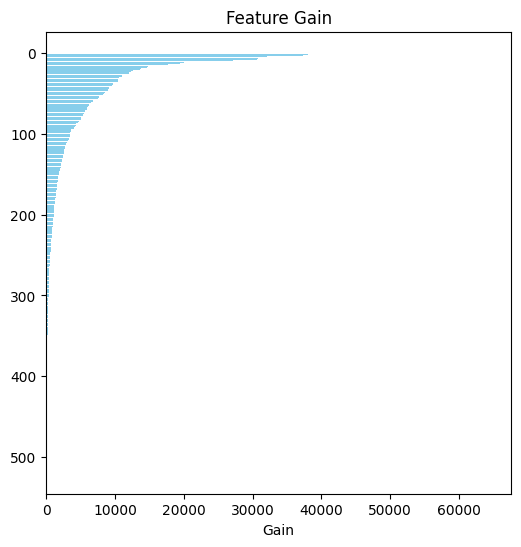

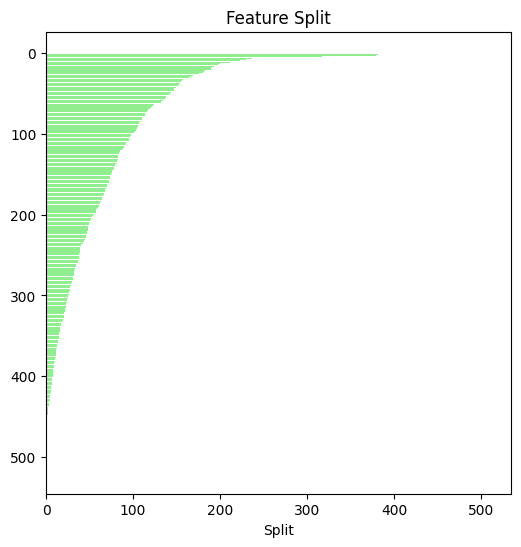

Shape before selection  (1526669, 681)
["avgdpdtolclosure24_3658938P", "mean_maxdpdtolerance_577P", "pctinstlsallpaidlate1d_3546856L", "price_1097A", "max_birth_259D", "pmtnum_254L", "mobilephncnt_593L", "max_incometype_1044T", "max_sex_738L", "lastrejectreason_759M", "lastrejectdate_50D", "sum_amount_4527230A", "avgdbddpdlast24m_3658932P", "days120_123L", "maxdbddpdtollast12m_3658940P", "lastst_736L", "mean_empl_employedfrom_271D", "numrejects9m_859L", "pctinstlsallpaidlate4d_3546849L", "days180_256L", "firstclxcampaign_1125D", "pmtssum_45A", "min_empl_employedfrom_271D", "lastcancelreason_561M", "maxdpdlast12m_727P", "dateofbirth_337D", "days90_310L", "maxdpdlast24m_143P", "validfrom_1069D", "numinstpaidearly3d_3546850L", "annuity_780A", "cntpmts24_3658933L", "max_relationshiptoclient_415T", "mean_outstandingdebt_522A", "credamount_770A", "numinstlswithdpd10_728L", "eir_270L", "max_employedfrom_700D", "max_firstnonzeroinstldate_307D", "pctinstlsallpaidlate6d_3546844L", "disbursedcred

Processing columns:   0%|          | 0/614 [00:00<?, ?it/s]

shape after normalizing (1526669, 617)

Column: amtinstpaidbefduel24m_4187115A, Min Value: 0.0, Max Value: 1408010.2
Column: annuity_780A, Min Value: 80.8, Max Value: 106007.0
Column: applicationscnt_867L, Min Value: 0.0, Max Value: 287.0
Column: avgdbddpdlast24m_3658932P, Min Value: -1220.0, Max Value: 4750.0
Column: avgdbddpdlast3m_4187120P, Min Value: -908.0, Max Value: 4750.0
Column: avgdbdtollast24m_4525197P, Min Value: -1220.0, Max Value: 4750.0
Column: avgdpdtolclosure24_3658938P, Min Value: 0.0, Max Value: 4750.0
Column: avgmaxdpdlast9m_3716943P, Min Value: 0.0, Max Value: 240.0
Column: avgoutstandbalancel6m_4187114A, Min Value: -7588198.5, Max Value: 1131135.9
Column: clientscnt12m_3712952L, Min Value: 0.0, Max Value: 198.0
Column: cntincpaycont9m_3716944L, Min Value: 0.0, Max Value: 575.0
Column: cntpmts24_3658933L, Min Value: 0.0, Max Value: 25.0
Column: credamount_770A, Min Value: 2000.0, Max Value: 950000.0
Column: currdebt_22A, Min Value: 0.0, Max Value: 1210629.1
Column:

In [36]:

if __name__ == "__main__":
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.max_columns', 100)
    with timer("Pipeline total time"):
        main(debug= False)

In [37]:
imported=pd.read_csv("/kaggle/input/home-credit-2024-additional-dataset/features_575.csv")
new_cols=imported["feature"].tolist()

In [38]:
formatted_list = ', '.join(['"' + item + '"' for item in new_cols])

print('[' + formatted_list + ']')

["month_decision", "weekday_decision", "credamount_770A", "applicationcnt_361L", "applications30d_658L", "applicationscnt_1086L", "applicationscnt_464L", "applicationscnt_867L", "clientscnt_1022L", "clientscnt_100L", "clientscnt_1071L", "clientscnt_1130L", "clientscnt_157L", "clientscnt_257L", "clientscnt_304L", "clientscnt_360L", "clientscnt_493L", "clientscnt_533L", "clientscnt_887L", "clientscnt_946L", "deferredmnthsnum_166L", "disbursedcredamount_1113A", "downpmt_116A", "homephncnt_628L", "isbidproduct_1095L", "mobilephncnt_593L", "numactivecreds_622L", "numactivecredschannel_414L", "numactiverelcontr_750L", "numcontrs3months_479L", "numnotactivated_1143L", "numpmtchanneldd_318L", "numrejects9m_859L", "sellerplacecnt_915L", "max_mainoccupationinc_384A", "max_birth_259D", "max_num_group1_9", "birthdate_574D", "dateofbirth_337D", "days180_256L", "days30_165L", "days360_512L", "firstquarter_103L", "fourthquarter_440L", "secondquarter_766L", "thirdquarter_1082L", "max_debtoutstand_525A